In [172]:
import pandas as pd
import numpy as np

In [173]:
df = pd.read_csv("powerplant_data.csv")

In [174]:
df.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


In [175]:
# here,AT => representing the Temperature in PowerPlant..
# V => it is representing the Vaccum in powerplant..
# AP => it is representing Pressure in powerplant..
# RH => it is representing the humidity in powerplant..

# here,PE => Produced Energy in the powerplant..

In [176]:
df.isnull().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

In [177]:
X = df.drop("PE",axis=1)
y = df["PE"]

In [178]:
X.head()

,AT,V,AP,RH
0,8.34,40.77,1010.84,90.01
1,23.64,58.49,1011.40,74.20
2,29.74,56.90,1007.15,41.91
3,19.07,49.69,1007.22,76.79
4,11.80,40.66,1017.13,97.20


In [179]:
# Split our data..
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(
    X,y ,test_size=0.2,random_state=42
)

In [180]:
df.shape

(9568, 5)

In [181]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [182]:
X_train_scaled

array([[ 0.74805289,  0.72006931, -0.32660017, -0.49711722],
       [ 0.86181948,  1.26515721, -0.98521113,  0.8181501 ],
       [ 0.93409473,  1.52314975,  0.32523844,  0.80167494],
       ...,
       [-0.22097078, -0.834965  ,  0.36756563, -0.83554456],
       [ 0.94747903,  1.14245344, -0.41971997, -0.45455637],
       [-1.77355014, -1.19049131,  1.92520594,  0.91837402]])

In [183]:
# converting X_train,X_test,y_train,y_test into tensors..
import torch
import torch.nn as nn
type(X_train_scaled) # here,it is an numpy array..

numpy.ndarray

In [184]:
type(y_train) # here, it is a series of pandas..

pandas.core.series.Series

In [185]:
X_train_tensor = torch.tensor(X_train_scaled,dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled,dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values,dtype=torch.float32).view(-1,1)
y_test_tensor = torch.tensor(y_test.values,dtype=torch.float32).view(-1,1)

In [186]:
from torch.utils.data import TensorDataset, DataLoader

In [187]:
train_dataset = TensorDataset(X_train_tensor,y_train_tensor)
test_dataset = TensorDataset(X_test_tensor,y_test_tensor)

In [188]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32)

 # Deep Learning Part starts from here..

In [189]:
# Build ANN Model..
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()

        self.model = nn.Sequential(
          # First Hidden Layer.
          nn.Linear(X_train.shape[1],6),
          nn.ReLU(),
          # Second Hidden Layer..
          nn.Linear(6,6),
          nn.ReLU(),
          # Output Layer..
          nn.Linear(6,1),
    )

    def forward(self,x):
        return self.model(x)

In [190]:
# defining the model..
import torch.optim as optim

model = ANN()
# LOSS-function and Optimizer..
crietrion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [191]:
# Train the ANN.
train_losses = []
valid_losses = []
best_valid_loss = float("inf")
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0 # total training loss for 1 epoch
    for xb,yb in train_loader:
        optimizer.zero_grad()
        # xb => features of 1 batch..
        # yb => labels of 1 batch..
        outputs = model(xb) # forward prop.. predicted outputs for this batch..
        loss = crietrion(outputs,yb) # compute loss..
        loss.backward() # back prop.. compute gradients
        optimizer.step() # param update..

        running_loss+=loss.item() # loss is a tensor value, used item we convert it into float..

    epoch_train_loss = running_loss/len(train_loader)
    train_losses.append(epoch_train_loss)

    # Validation part..
    running_loss = 0.0
    model.eval()
    with torch.no_grad():
        for xb,yb in test_loader:
            outputs = model(xb)
            loss = crietrion(outputs,yb)
            running_loss+= loss.item()
    epoch_valid_loss = running_loss/len(test_loader)
    valid_losses.append(epoch_valid_loss)

    print(f"epoch ${epoch+1}/{epoch}==> train loss = {epoch_train_loss} & valid = {epoch_valid_loss}")
    if epoch_valid_loss<best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(),"best_model.pt") # either .pt or .pth..
        

epoch $1/0==> train loss = 205360.2765625 & valid = 201884.39088541668
epoch $2/1==> train loss = 191252.4734375 & valid = 174442.92994791668
epoch $3/2==> train loss = 146111.8549153646 & valid = 113042.83802083334
epoch $4/3==> train loss = 80931.17013346354 & valid = 53081.72447916667
epoch $5/4==> train loss = 37573.720483398436 & valid = 27501.99453125
epoch $6/5==> train loss = 23234.821643066407 & valid = 20190.63601888021
epoch $7/6==> train loss = 17948.879939778646 & valid = 15894.830436197917
epoch $8/7==> train loss = 14040.809440104167 & valid = 12097.76748860677
epoch $9/8==> train loss = 10418.310666910807 & valid = 8683.43358561198
epoch $10/9==> train loss = 7244.577082316081 & valid = 5788.607446289063
epoch $11/10==> train loss = 4670.950710042318 & valid = 3597.298443603516
epoch $12/11==> train loss = 2875.762151590983 & valid = 2233.8240915934243
epoch $13/12==> train loss = 1806.1794876098634 & valid = 1443.7228393554688
epoch $14/13==> train loss = 1186.94965222

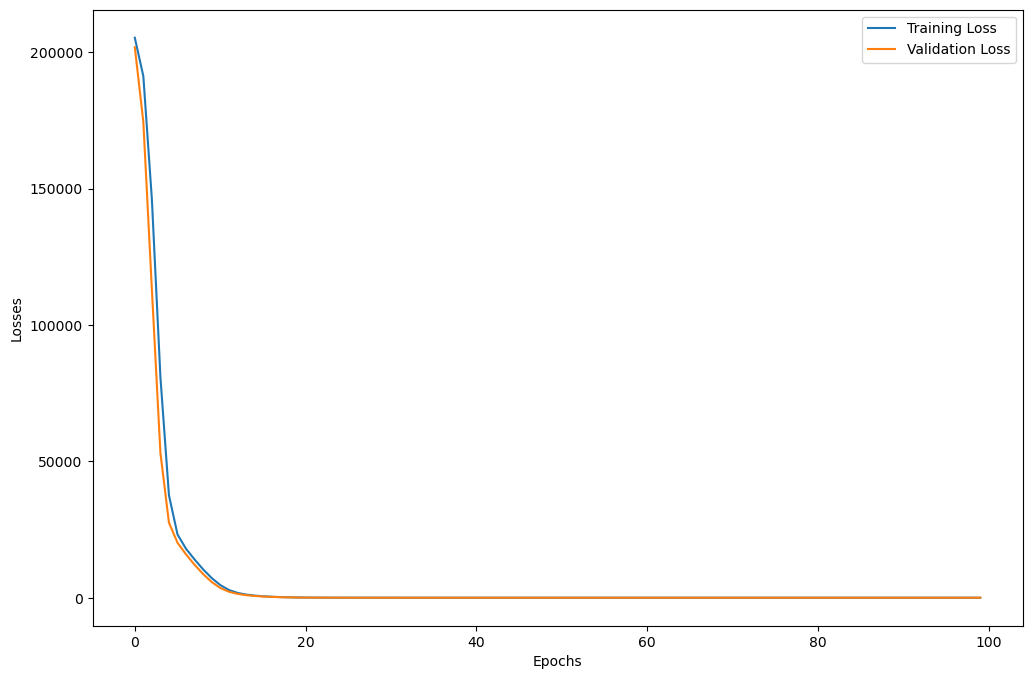

In [192]:
# Visualization..
import matplotlib.pyplot as plt
loss_df = pd.DataFrame({
    "Training Loss":train_losses,
    "Validation Loss":valid_losses
})
plt.figure(figsize=(12,8))
plt.plot(loss_df["Training Loss"],label="Training Loss")
plt.plot(loss_df["Validation Loss"],label="Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()

In [193]:
# Loading the best model..
model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

In [198]:
# Evaluation..
model.eval()
with torch.no_grad():
    train_pred = model(X_train_tensor)
    test_pred = model(X_test_tensor)

    train_mse_loss=crietrion(train_pred,y_train_tensor)
    test_mse_loss=crietrion(test_pred,y_test_tensor)

print("Training MSE:",train_mse_loss.item())
print("Testing MSE:",test_mse_loss.item())

Training MSE: 19.889036178588867
Testing MSE: 18.04129981994629


In [199]:
from sklearn.metrics import r2_score

print("r^2 score =",r2_score(y_test,test_pred))

r^2 score = 0.9369503212928469


In [202]:
predicted_df = pd.DataFrame(test_pred.numpy(),columns=["Predicted Values"])
actual_df =pd.DataFrame(y_test.values,columns=["Actual Values"])
pd.concat([predicted_df,actual_df],axis=1)

,Predicted Values,Actual Values
0,435.089264,433.27
1,435.600861,438.16
2,460.939606,458.42
3,477.186005,480.82
4,435.236176,441.41
...,...,...
1909,451.329102,456.70
1910,431.148773,438.04
1911,466.955231,467.80
1912,430.251404,437.14
